In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Icehockey')

In [3]:
data = dm.__get_data__()

In [4]:
data.head()

odds        prob        \
                                                     0     1     0     1   
MatchDate  HomeTeam    AwayTeam   bkmr                                     
2010-05-07 USA         Germany    unibet_op_ha_   3.65  1.25  0.26  0.74   
2010-05-08 Finland     Denmark    unibet_op_ha_  11.00  1.02  0.08  0.92   
           Switzerland Latvia     unibet_op_ha_   2.80  1.40  0.33  0.67   
2010-05-09 Belarus     Kazakhstan unibet_op_ha_   3.55  1.26  0.26  0.74   
           Norway      Sweden     unibet_op_ha_  10.50  1.02  0.09  0.91   

                                                  book FTR  
                                                            
MatchDate  HomeTeam    AwayTeam   bkmr                      
2010-05-07 USA         Germany    unibet_op_ha_  0.074   0  
2010-05-08 Finland     Denmark    unibet_op_ha_  0.071   0  
           Switzerland Latvia     unibet_op_ha_  0.071   1  
2010-05-09 Belarus     Kazakhstan unibet_op_ha_  0.075   1  
           Norway      Sweden     unibet_op_ha_  0.076   1

In [5]:
train = data[data.index.get_level_values(0) < datetime(2018, 1, 1)]
test  = data[data.index.get_level_values(0) > datetime(2018, 1, 1)]

In [6]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 0), ('prob', 1), 'book', 'FTR'])
matrix = matrix.stack().unstack(level=2)
matrix = matrix[matrix.sum(axis=1) > 100].stack().unstack(level=2).fillna(0)

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [7]:
matrix.head()

book                     0.051  0.083  0.047  0.077  0.044  0.056  0.042  \
(prob, 0) (prob, 1) FTR                                                    
0.17      0.83      0     19.0    0.0    0.0    0.0    0.0    0.0    0.0   
                    1    105.0    0.0    0.0    0.0    0.0    0.0    0.0   
0.18      0.82      0      0.0   16.0    0.0    0.0    0.0    0.0    0.0   
                    1      0.0   94.0    0.0    0.0    0.0    0.0    0.0   
0.19      0.81      0      0.0    0.0   23.0   20.0    0.0    0.0    0.0   

book                     0.078  0.082  0.055  ...  0.025  0.041  0.036  0.040  \
(prob, 0) (prob, 1) FTR                       ...                               
0.17      0.83      0      0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
                    1      0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
0.18      0.82      0      0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
                    1      0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
0.19      0.81      0      0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   

book                     0.057  0.014  0.064  0.026  0.062  0.073  
(prob, 0) (prob, 1) FTR                                            
0.17      0.83      0      0.0    0.0    0.0    0.0    0.0    0.0  
                    1      0.0    0.0    0.0    0.0    0.0    0.0  
0.18      0.82      0      0.0    0.0    0.0    0.0    0.0    0.0  
                    1      0.0    0.0    0.0    0.0    0.0    0.0  
0.19      0.81      0      0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 69 columns]

In [9]:
test   = test.reset_index(level=3).set_index(['book','bkmr'], append=True)
vicini = test.prob.apply(get_neighbours, axis=1).rename('NN').to_frame()

probs  = vicini.apply(dm.ubibetter.__compute_probs__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [10]:
probs.head()

KLFY  \
                                                                      0   
MatchDate  HomeTeam        AwayTeam     book  bkmr                        
2018-01-02 Biel            Fribourg     0.071 bwin_op_ha_      0.362069   
                                        0.019 marathon_op_ha_  0.431066   
           Davos           Bern         0.021 marathon_op_ha_  0.398884   
           EHC Kloten      Ambri-Piotta 0.071 bwin_op_ha_      0.462687   
           Eisbaren Berlin Schwenninger 0.048 bet365_op_ha_    0.315545   

                                                                         
                                                                      1  
MatchDate  HomeTeam        AwayTeam     book  bkmr                       
2018-01-02 Biel            Fribourg     0.071 bwin_op_ha_      0.637931  
                                        0.019 marathon_op_ha_  0.568934  
           Davos           Bern         0.021 marathon_op_ha_  0.601116  
           EHC Kloten      Ambri-Piotta 0.071 bwin_op_ha_      0.537313  
           Eisbaren Berlin Schwenninger 0.048 bet365_op_ha_    0.684455

In [11]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=5).merge(test['FTR'], right_index=True, left_index=True)
aux = aux.reset_index(level=3, drop=True)
aux = aux.rename(columns={'level_5':'level_4'})

In [12]:
aux.head(6)

level_4   odd      prob  FTR
MatchDate  HomeTeam AwayTeam bkmr                                         
2018-01-02 Biel     Fribourg marathon_op_ha_        0  2.38  0.431066    1
                             marathon_op_ha_        1  1.67  0.568934    1
                             bwin_op_ha_            0  2.35  0.362069    1
                             bwin_op_ha_            1  1.55  0.637931    1
           Davos    Bern     marathon_op_ha_        0  2.33  0.398884    0
                             marathon_op_ha_        1  1.69  0.601116    0

In [13]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction).rename('frac').to_frame()
aux  = pd.concat([aux.set_index('level_4', append=True), frac.round(4)], axis=1).reset_index(level=4)

In [14]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [15]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

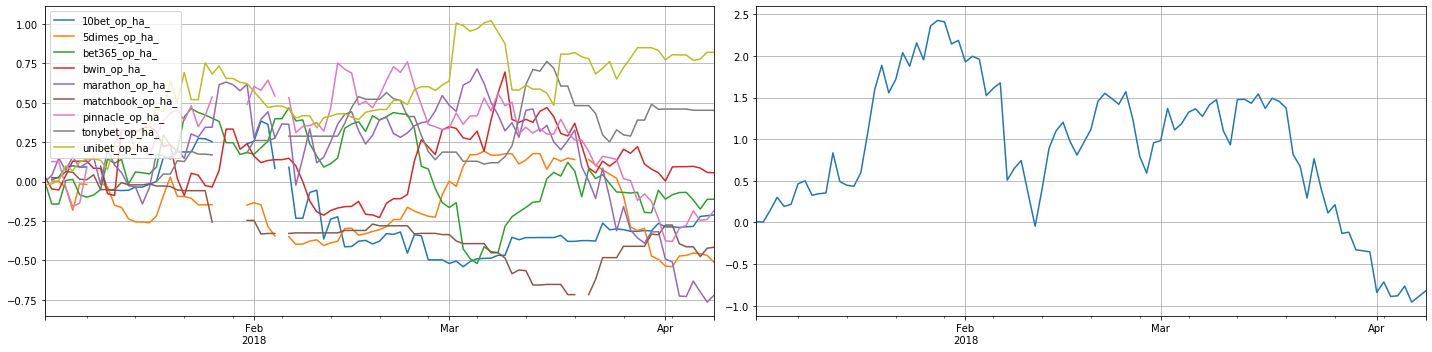

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0], grid=True)
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1], grid=True)
plt.tight_layout()